# L2 - Полносвязанная сеть

### 1. Многоклассовая классификация

Итак, мы знакомы уже с бинарным линейным классификатором
$$y = \text{sign}(wx).$$
Существуют [разные](https://en.wikipedia.org/wiki/Multiclass_classification) подходы к задаче многоклассовой классификции, к примеру [сведение](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) задачи к бинарной классификации, [модификация модели](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) и т.п. Нам же интересен подход, который применяется в нейронных сетях.

Для каждого класса из набора $1 \dots |C|$ заведем свой вектор весов $w_i$ и уложим это все в матрицу $W$ построчно. Для простоты будем считать, что $w_i$ - строка. Тогда наш классификатор будет выглядеть следующим образом
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx),$$
где $p_i$ - вероятность, что объект относится к классу $i$, при этом
$$p_i = \frac{\exp(w_ix)}{\sum_j \exp(w_jx)}.$$
Если внимательно присмотреться, то $\text{softmax}$ является обобщенным вариантом сигмоиды. Для того, чтобы убедиться в этом, достаточно расписать случай для $|C|=2$.

Как и для задачи бинарной классификации, обучение можно свести к минимизации эмпирического риска, то есть к оптимизации следующего функционала
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Очевидно, что сверху написано ни что иное, как максимизация логарифма правдоподобия.

**Задание**
1. Вычислите градиент функции $Q$ (попробуйте провести выкладки для отдельной строки $w_i$).
2. Обучите модель с помощью градиентного спуска на выборке [mnist](https://www.kaggle.com/c/digit-recognizer) (вы можете применить свою любимую вариацию метода).
3. Вычислите качество на отоженной выборке.

$$Имеем \space Q = -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W))$$

$$ Q(W) = -[y = i]\cdot\log\frac{exp(W_{i}x)}{\sum_{j}exp(W_{j}x)} = [y = i]\cdot(\log(\sum_{j}exp(W_{j}x)) - \log(exp(W_{i}x))) = [y = i]\cdot(\log(\sum_{j}exp(W_{j}x)) - W_{i}x)$$

$$Тогда \space Q'(W_i^k) = x_k\cdot[y = i]\cdot(\frac{\sum_{j}exp(W_{j}x)'}{\sum_{j}exp(W_{j}x)} - 1)$$

In [1]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')
        
        

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
data = pd.read_csv("train.csv")

data_y = data['label']
del data['label']

data = data.as_matrix()
data_y = data_y.tolist()

data = StandardScaler().fit_transform(data)

temp = []

for elem in data_y:
    temp_vec = [0 for i in range(10)]
    temp_vec[elem] = 1
    temp.append(temp_vec)
    
data_y = np.array(temp)

X_train, X_test, Y_train, Y_test = train_test_split(
    data, data_y, test_size=0.2)

/usr/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [68]:
class Dense():
    def __init__(self, inp, out):
        self.W = np.random.randn(inp, out) * 0.1
        self.b = np.zeros(out)
        
    def get_params_iter(self):
        for it in [self.W, self.b]:
            for element in it:
                yield element
    
    def get_output(self, X):
        return X @ self.W + self.b
        
    def get_params_grad(self, X, output_grad):
        der_W = X.T @ output_grad
        der_b = np.sum(output_grad, axis=0)
        temp = []
        for it in [der_W, der_b]:
            for element in it:
                temp.append(element)
        return temp
    
    def get_input_grad(self, output_grad=None, T=None):
        return output_grad @ self.W.T
    
    
class Nonlinearity():
    def __init__(self, name = "sigmoid"):
        self.name = name
    
    def get_output(self, X):
        if self.name == "relu":
            np.clip(X, 0, np.finfo(X.dtype).max, out=X)
            return X
        if self.name == "sigmoid":
            return 1 / (1 + np.exp(-X))
        if self.name == "identity":
            return X
    
    def get_params_grad(self, X, output_grad):
        return []
    
    def get_params_iter(self):
        return []
    
    def get_input_grad(self, Y, output_grad):
        if self.name == "relu":
            def der_relu(x):
                if (x < 0).all:
                    return 0
                else:
                    return 1   
            result = der_relu(Y)
            return np.array(result)
        if self.name == "sigmoid":
            return np.multiply(Y, (1 - Y)) * output_grad
        if self.name == "identity":
            return np.sign(Y)
            
    
class Softmax():
    def __init__(self, reg = "None", alpha_l1 = 0.1, alpha_l2 = 0.1):
        self.reg = reg
        self.alpha_l1 = alpha_l1
        self.alpha_l2 = alpha_l2
        
    def get_output(self, X):
        return np.exp(X)/np.sum(np.exp(X),axis=1, keepdims=True)
    
    def get_input_grad(self, Y, T):
        if self.reg == "None":
            return (Y - T) / Y.shape[0]
        if self.reg == "L1":
            return (Y - T) / Y.shape[0] + (self.alpha_l1 * np.sign(X)).sum()
        if self.reg == "L2":
            return (Y - T) / Y.shape[0] + (self.alpha_l2 * 2 * X).sum()
        if self.reg == "both":
            return (Y - T) / Y.shape[0] + (self.alpha_l2 * 2 * X).sum() + (self.alpha_l1 * np.sign(X)).sum()
    
    def get_params_grad(self, X, output_grad):
        return []
    
    def get_params_iter(self):
        return []
    
def forward_step(input_samples, layers):
    activations = [input_samples]
    temp_dat = []
    X = input_samples
    for layer in layers:
        Y = layer.get_output(X)
        temp_dat.append(X)
        activations.append(Y)
        X = activations[-1]
    return activations, temp_dat

def backward_step(activations, targets, layers):
    param_grads = collections.deque()
    output_grad = None
    for layer in layers[::-1]:
        Y = activations.pop()
        temp_X = temp_dat.pop()
        if output_grad is None:
            input_grad = layer.get_input_grad(Y, targets)
        else:
            input_grad = layer.get_input_grad(Y, output_grad)
        X = activations[-1]
        grads = layer.get_params_grad(X, output_grad)
        param_grads.appendleft(grads)
        output_grad = input_grad
    return list(param_grads)


def batch_iterator(X_train, Y_train, batch_size):
    for i in range(int(X_train.shape[0] / batch_size)):
        yield [X_train[i * batch_size : i * batch_size + batch_size],
               Y_train[i * batch_size : i * batch_size + batch_size]]

def update_params(layers, param_grads, learning_rate):
    for layer, layer_backprop_grads in zip(layers, param_grads):
        for param, grad in zip(layer.get_params_iter(), layer_backprop_grads):
            param -= learning_rate * grad

In [69]:
layers = []

layers.append(Dense(X_train.shape[1], 10))
layers.append(Softmax())

In [319]:
max_nb_of_iterations = 5
learning_rate = 0.1
batch_size = 1000
import time

for iteration in range(max_nb_of_iterations):
    begin = time.time()
    for X, T in batch_iterator(X_train, Y_train, batch_size): 
        activations, temp_dat = forward_step(X, layers)
        param_grads = backward_step(activations, T, layers, temp_dat)
        update_params(layers, param_grads, learning_rate)
    print(time.time() - begin)

0.9928193092346191
1.0338892936706543
1.016998529434204
0.9951286315917969
1.1504430770874023


In [320]:
y_true = np.argmax(Y_test, axis=1)
activations = forward_step(X_test, layers)
y_pred = np.argmax(activations[-1][1], axis=1) 
test_accuracy = metrics.accuracy_score(y_true, y_pred)
print('The accuracy = ', test_accuracy)

The accuracy =  0.891071428571


Давайте кратко каснемся темы регуляризации. Как было рассказано на семинаре, подходы есть разные. Мы же остановимся на модификации оптимизируемого функционала.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - пытается занулить бесполезные признаки
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - не дает параметрам быть слишком большими.

**Задание**
1. Как стоит подбирать значения $\lambda_1$ и $\lambda_2$?
2. Удалось ли улучшить $Q$ на отложенной выборке?

In [294]:
accuracy_per_reg = []
xs = []
ys = []

for j in log_progress(range(20)):
    for i in log_progress(range(20)):
        layers = []

        layers.append(Dense(X_train.shape[1], 10))
        layers.append(Softmax(reg="both", alpha_l1 = 0.05 * i, alpha_l2 = 0.05 * j))
        
        xs.append(0.05 * i)
        ys.append(0.05 * j)

        max_nb_of_iterations = 5
        learning_rate = 0.1
        batch_size = 1000
        import time

        for iteration in range(max_nb_of_iterations):
            for X, T in batch_iterator(X_train, Y_train, batch_size): 
                activations, temp_dat = forward_step(X, layers)
                param_grads = backward_step(activations, T, layers, temp_dat)
                update_params(layers, param_grads, learning_rate)

        y_true = np.argmax(Y_test, axis=1)
        activations = forward_step(X_test, layers)
        y_pred = np.argmax(activations[-1][1], axis=1) 
        test_accuracy = metrics.accuracy_score(y_true, y_pred)
        accuracy_per_reg.append(test_accuracy)

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:63: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.5/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in true_divide


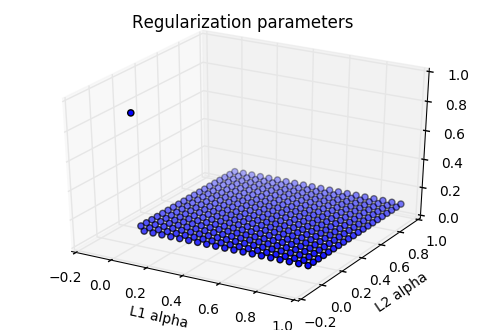

In [302]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title("Regularization parameters")
plt.xlabel("L1 alpha")
plt.ylabel("L2 alpha")
ax.scatter(xs, ys, accuracy_per_reg)

Регуляризаторы не работают =(

### 2. Полносвязанные нейронные сети

Можно задаться вопросом, а что будет, если поверх модели $Wx$ применить еще одну матрицу, а затем уже $\text{softmax}$? Ответ следующий, дополнительное умножение на матрицу слева $W_2\cdot(W_1x)$ ничего не даст, в итоге это та же самая модель $Wx$, где $W=W_2 W_1$. А вот, если между матрицами добавить третий "слой", то может получиться очень интерсная штука.

Давайте рассмотрим пример на множестве бинарных функций, $x \in \{0, 1\}^{2}$. Пусть есть модель

$$y = \theta(wx + b),$$

где $\theta$ - функция [Хевисайда](https://en.wikipedia.org/wiki/Heaviside_step_function).

**Задание**
1. Предложите значения $w$ и $b$, чтобы $y$ реализовала операторы *and*, *or*, *not*.
2. Приведите пример булевой функции, которая не может быть представлена в виде $y$?

1. And: $w_1 = 1/2, w_2 = 1/2,  b = -2/3$

   Or: $w_1 = 1/2, w_2 = 1/2,  b = -1/3$
   
   Not: $w = -1,  b = 1/2$
    
    
2. XOR

Давайте рассмотрим случай посложнее, пусть теперь $x \in \{0, 1\}^{n}$, а
$$y = \theta(W_2 \cdot \theta(W_1x + b_1) + b_2),$$
где функция $\theta$ для вектора применяется поэлементно. Кстати, судя по размерности, $W_2$ - вектор, но для общности записан с большой буквы.

**Задание**
1. Можете ли вы теперь представить вашу функцию в виде $y$?
2. Может ли $y$ реализовать произвольную булеву функцию? Знаете ли вы, что такое ДНФ?

В общем виде будем иметь:

1. AND : $w_1 = diag(1, 1, ..., 1), w_2 = diag(1, 1, ..., 1), b_1 = diag(-1/2, -1/2, ..., -1/2), b_2 = -n + 1/2$
2. OR : $w_1 = diag(1, 1, ..., 1), w_2 = diag(1, 1, ..., 1), b_1 = (0, 0, 0, ..., 0), b_2 = -1/2$

Тогда, так как выразимы and, or, not, то выразима и любая функция представимая в виде ДНФ.

Теперь мы получили интуицию, почему сочетание нелинейности и нескольких линейных слоев могут дать поразительный эффект! Очевидно, что эту же идею можно переложить и на задачу классификации в пространстве признаков $\mathbb{R}^n$.
Одним словом, мы изобрели полносвязанную нейронную сеть!

Конструкция сети обычно выглядит следующим образом. На вектор признаков $x_1$ сначала применяется линейное преобрзование $W_1$ и некоторая нелинейная функция $\sigma_1$. На выходе мы получаем вектор $x_2$. К нему может быть применена очередная пара $W_2$ и $\sigma_2$ и т.д. Для задачи классификации в частности все заканчивается слоем $\text{softmax}$, которые применяется к выходу $x_{n}$. Теперь, пропустив входной вектор $x_1$ через все эти слои, получим оценку вероятности принадлежности каждому классу.

Некоторые полезные факты:
1. Двуслойная сеть в $\mathbb{R}^n$ позволяет реализовать произвольный выпуклый многогранник.
2. Трехслойная сеть в $\mathbb{R}^n$ позволяет определить уже не обязательно выпуклую и даже не обязательно связанную область.
3. С помощью линейных операций и фиксированной функции $\sigma$ можно приблизить функцию с коль угодной точностью.

### 3. Обучение

Осталось только понять, как все эти слои обучить. Для этого нам понадобиться ввести кое-какие обозначения. Пусть есть некоторая функция, которая на вход принимает вектор $x = (x_1, \dots, x_n)$ и выдает $y = (y_1, \dots, y_m)$, то есть размерности могу не совпадать, тогда

$$\frac{dy}{dx} = \Big[g_{ij} = \frac{\partial y_j}{\partial x_i}\Big].$$

Не нарушая общности можно предположить, что каждый слой это функция $$f_i(x_i, w_i) = x_{i+1}.$$ При этом для обучения в самый конец добавляется слой с вычислением ошибки. Таким образом всю работу такой сети можно обозначить за $Q$, которая принимает $x_1$ и возвращает некоторое значение ошибки.

**Forward step**

Первым делом просто запускаем вычисления по слоям и узнаем все значения $x_i$. Тут все просто и справится даже школьник.

**Backward step**

Рассмотрим последний слой, градиентный шаг для $w_n$ вычисляется очевидным образом $\frac{dQ}{dw_n}$. При этом на всякий случай вычислим еще и $\frac{dQ}{dx_{n}}$. 

Теперь на необходимо посчитать то же самое на слой ниже, но на семинаре мы подробно обсуждали, что 
$$\frac{dQ}{dw_{n-1}} = \frac{dx_{n}}{dw_{n-1}}\frac{dQ}{dx_{n}} \text{ и } \frac{dQ}{dx_{n-1}} = \frac{dx_{n}}{dx_{n-1}}\frac{dQ}{dx_{n}}.$$
То есть теперь мы вычислили градиент для парамтеров слоем ниже. Повторяя таки образом операции, вычислим $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$ и т.д.

Теперь, когда градиент найден, мы можем спокойно применить метод градиентного спуска для обучения весов. Стоит отметить, что сети обучают именно таким подходом, при этом для лучшего обучения повсеместно применяется батчинг.

**Моменты реализации**

Итак, нейросеть удобно реализовывать в виде слоев $y=f(x, w)$, где у каждого слоя есть следующие методы:
* $f$ - вычисляет значение слоя для  текущего значения $w$ и вектора $x$.
* $dydw$ - метод необходимый для вычисление шага градиентного спуска
* $dydx$ - метод необходим для вычисления шага для слоя ниже
* $update$ -  обновляет параметр $w$ для слоя на указанную величину

Тогда, если есть список слоев и определена функция потерь последним дополнительным слоем, то обучение сводиться к запуска forward вычислений, а затем постепенном обратном распространении ошибки и обновления параметров, то есть шаг $backward$. Будьте аккуратны при реализации.

**Задание**

1. Реализуйте двухслойную сеть, где в качестве нелинейной функции используется [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks).
2. Улучшилось ли качество в сравнении с предыдущей моделью?
3. Какова размерность выходного вектора после первого линейного преобразования? Как влияет его размер?

In [376]:
hidden_neurons_1 = 30
hidden_neurons_2 = 10  
layers = []

layers.append(Dense(X_train.shape[1], hidden_neurons_1))
layers.append(Nonlinearity(name='relu'))

layers.append(Dense(hidden_neurons_1, hidden_neurons_2))
layers.append(Nonlinearity(name='relu'))

layers.append(Dense(hidden_neurons_2, Y_train.shape[1]))
layers.append(Softmax())

In [357]:
from sklearn import datasets, cross_validation, metrics
import itertools
import collections

In [377]:
max_nb_of_iterations = 5
learning_rate = 0.1
batch_size = 1000
import time

for iteration in range(max_nb_of_iterations):
    begin = time.time()
    for X, T in batch_iterator(X_train, Y_train, batch_size): 
        activations, temp_dat = forward_step(X, layers)
        param_grads = backward_step(activations, T, layers)
        update_params(layers, param_grads, learning_rate)
    print(time.time() - begin)

7.152688026428223
7.0878214836120605
7.067523956298828
7.124407052993774
6.9789135456085205


In [379]:
y_true = np.argmax(Y_test, axis=1)
activations = forward_step(X_test, layers)
y_pred = np.argmax(activations[-1][1], axis=1) 
test_accuracy = metrics.accuracy_score(y_true, y_pred)
print('The accuracy = ', test_accuracy)

The accuracy =  0.930714285714


Качество улучшилось довольно значительно.

In [386]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 20

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=0, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_10 (Dense)                 (None, 512)           401920      dense_input_4[0][0]              
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 512)           0           dense_10[0][0]                   
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 512)           262656      activation_10[0][0]              
____________________________________________________________________________________________________
activation_11 (Activation)       (None, 512)           0           dense_11[0][0]                   
___________________________________________________________________________________________

In [402]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 20

accuracy = []

for deep in range(1, 10):

    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))

    for elem in range(deep):
        model.add(Dense(512))
        model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    accuracy.append(score)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_312 (Dense)                (None, 512)           401920      dense_input_106[0][0]            
____________________________________________________________________________________________________
activation_311 (Activation)      (None, 512)           0           dense_312[0][0]                  
____________________________________________________________________________________________________
dense_313 (Dense)                (None, 512)           262656      activation_311[0][0]             
____________________________________________________________________________________________________
activation_312 (Activation)      (None, 512)           0           dense_313[0][0]                  
___________________________________________________________________________________________

Да, относительно простой модели Softmax качество значительно улучшилось.

In [415]:
from __future__ import print_function
import numpy as np
np.random.seed(1337)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 20

accuracy = []

for deep in range(1, 1000, 50):

    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))

    
    model.add(Dense(deep))
    model.add(Activation('relu'))

    model.add(Dense(10))
    model.add(Activation('softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])

    history = model.fit(X_train, Y_train,
                        batch_size=batch_size, nb_epoch=nb_epoch,
                        verbose=0, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    accuracy.append(score)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_390 (Dense)                (None, 512)           401920      dense_input_118[0][0]            
____________________________________________________________________________________________________
activation_389 (Activation)      (None, 512)           0           dense_390[0][0]                  
____________________________________________________________________________________________________
dense_391 (Dense)                (None, 1)             513         activation_389[0][0]             
____________________________________________________________________________________________________
activation_390 (Activation)      (None, 1)             0           dense_391[0][0]                  
___________________________________________________________________________________________

Так как размерность выразима через размерность матриц, получаем линейную зависимость от размера слоя.

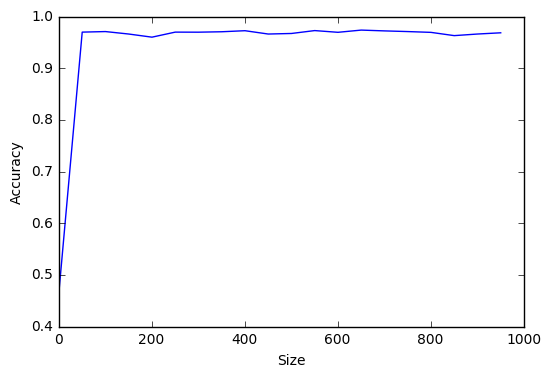

In [421]:
plt.xlabel("Size")
plt.ylabel("Accuracy")
plt.plot([i for i in range(1, 1000, 50)], accuracy)

Автоенкодеры

In [27]:
batch_size = 1000
nb_epoch = 30

layers = [
    Dense(784, input_shape=(784,)),
    Activation('relu')
]

autoencoder = Dense(784, input_shape=(784,))

for num in range(1, 5):
    model = Sequential(layers[:len(layers) - 2] + [autoencoder])
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'])
    
    model.fit(X_train, X_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=2)
    
    model = Sequential(layers)    
    autoencoder = Dense(784)

    layers.append(Dense(784))
    layers.append(Activation('relu'))
    
    
layers.append(Dense(10))
layers.append(Activation('softmax'))

model = Sequential(layers)
model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])
    
model.fit(X_train, Y_train,batch_size=batch_size,
          nb_epoch=nb_epoch * 10, verbose=1,
          validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
0s - loss: -1.8760e+01 - acc: 0.0047
Epoch 2/30
0s - loss: 8.9985 - acc: 0.0099
Epoch 3/30
0s - loss: 36.1823 - acc: 0.0131
Epoch 4/30
0s - loss: 86.0980 - acc: 0.0159
Epoch 5/30
0s - loss: 30.2850 - acc: 0.0229
Epoch 6/30
0s - loss: 42.5165 - acc: 0.0232
Epoch 7/30
0s - loss: 36.8563 - acc: 0.0213
Epoch 8/30
0s - loss: 25.2606 - acc: 0.0213
Epoch 9/30
0s - loss: 8.5517 - acc: 0.0268
Epoch 10/30
0s - loss: -2.4929e+01 - acc: 0.0313
Epoch 11/30
0s - loss: -3.4480e+01 - acc: 0.0342
Epoch 12/30
0s - loss: -2.9874e+01 - acc: 0.0320
Epoch 13/30
0s - loss: -1.7512e+01 - acc: 0.0321
Epoch 14/30
0s - loss: 39.4318 - acc: 0.0341
Epoch 15/30
0s - loss: 10.6014 - acc: 0.0362
Epoch 16/30
0s - loss: -1.4070e+01 - acc: 0.0404
Epoch 17/30
0s - loss: -2.3448e+00 - acc: 0.0441
Epoch 18/30
0s - loss: -3.5327e+01 - acc: 0.0460
Epoch 19/30
0s - loss: -6.2744e+01 - acc: 0.0476
Epoch 20/30
0s - loss: 30.6569 - acc: 0.0475
Epoch 21/30
0s - loss: 42.4920 - acc: 0.0471
Epoch 22/30
0s - loss: -6.4521

Никакого улучшения или прогресса =(

**Задание***

Предложите свою архитектуру полносвязанной сети, которая показывает лучшее качество на mnist. Вы вольны использовать произвольное количество слоев, другие [функции активации](https://en.wikipedia.org/wiki/Activation_function) и т.д.

In [414]:
batch_size = 128
nb_classes = 10
nb_epoch = 200

model = Sequential()
model.add(Dense(784, input_shape=(784,)))
model.add(Activation('relu'))

model.add(Dropout(p=0.2))

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=nb_epoch,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_387 (Dense)                (None, 784)           615440      dense_input_117[0][0]            
____________________________________________________________________________________________________
activation_386 (Activation)      (None, 784)           0           dense_387[0][0]                  
____________________________________________________________________________________________________
dropout_7 (Dropout)              (None, 784)           0           activation_386[0][0]             
____________________________________________________________________________________________________
dense_388 (Dense)                (None, 256)           200960      dropout_7[0][0]                  
___________________________________________________________________________________________